In [422]:
# ------------------------------------------------- #
# This notebook is used to compare the performance  #
# of scarlet1 and 2 on fitting a single source      #
# with an intentionally poor initialised spectrum   #
# Author: Matt Sampson Sept. 2023                   #
# ------------------------------------------------- #

In [423]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [424]:
import numpy as np
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
from numpyro.distributions import constraints
from scarlet2 import *
import matplotlib.pyplot as plt
import pandas as pd
from scarlet2 import nn

In [425]:
# plot params
# plot params
plt.rcParams["xtick.top"] = True 
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.direction"] = 'in' 
plt.rcParams["ytick.direction"] = 'in' 
plt.rcParams["xtick.minor.visible"] = True 
plt.rcParams["ytick.minor.visible"] = True 
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["xtick.minor.size"] = 4.5
plt.rcParams["ytick.major.size"] = 7
plt.rcParams["ytick.minor.size"] = 4.5
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

#plt.style.use('dark_background')

In [426]:
# ----------------------------------- #
# grab images from the HSC catalogue  #
# read them into jax arrays and then  #
# make a multi-band image             #
# ----------------------------------- #

# read in the single test galaxy from HSC
data_name = 'data_HSC_9697_patch_72.pkl' # storing just one patch locally so use it
df = pd.read_pickle(data_name) # 13827 is cool
data = df[df['parent_ID']==df['parent_ID'][4000]] 


# make multi-band data
multi_images = np.array([np.array(data['scene_g'])[0] , np.array(data['scene_r'])[0]  , np.array(data['scene_i'])[0]  , 
                        np.array(data['scene_y'])[0]  , np.array(data['scene_z'])[0] ]) 
multi_var = np.array([np.array(data['var_g'])[0] , np.array(data['var_r'])[0]  , np.array(data['var_i'])[0]  , 
                        np.array(data['var_y'])[0]  , np.array(data['var_z'])[0] ]) 
multi_psf = np.array([np.array(data['PSF_g'])[0] , np.array(data['PSF_r'])[0]  , np.array(data['PSF_i'])[0]  , 
                        np.array(data['PSF_y'])[0]  , np.array(data['PSF_z'])[0] ]) 

# box and center params
centers = jnp.asarray( [(src[0], src[1]) for src in data["loc"]] )
box_size = jnp.asarray( [(src) for src in data["box_sz"]] )

# set it up for scarlet
images = multi_images 
weights = 1/multi_var 
frame_psf = GaussianPSF(0.7)
model_frame = Frame(Box(images.shape), psf=frame_psf)
psf = multi_psf
obs = Observation(images, weights, psf=ArrayPSF(jnp.asarray(psf)))
obs.match(model_frame);
print('----------------------------------------')
print(f"    Scene contains {len(centers)} galaxy sources")
print('----------------------------------------')

----------------------------------------
    Scene contains 1 galaxy sources
----------------------------------------


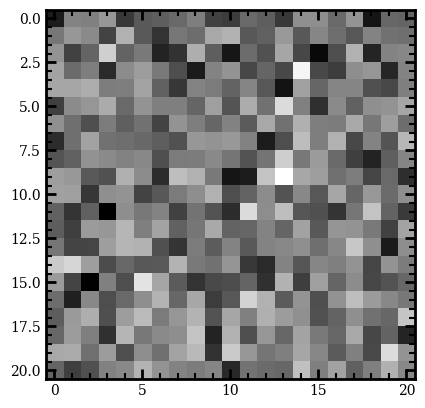

In [427]:
# define initial circular model for initial morphology estimate 
from skimage import draw

# empty list
morph_init = [None]*len(centers)
scarlet1_init = [None]*len(centers)
key = random.split(random.PRNGKey(0), 1)
sigma = .2 # noise factor

for i, bx in enumerate(box_size):
    arr = np.zeros((bx, bx))
    rr, cc = draw.disk((bx/2, bx/2), radius=bx/8, shape=arr.shape)
    arr[rr, cc] = 1
    noise = random.normal(key, (box_size[i], box_size[i]))
    raw =  arr + sigma * noise 
    raw = sigma * noise
    normed = (raw-jnp.min(raw))/(jnp.max(raw)-jnp.min(raw)) 
    morph_init[i] = normed
    
    # add scarlet initialisation, use i-band here for no significant reason
    scarlet1_init[i] = np.array([np.array(data['scar_i'])[i] ])[0]

plt.imshow(morph_init[0], cmap='gray')

# load the scarlet 1 initialisations
scarlet1_spec = np.load('scarlet1_spectrum.npy')
scarlet1_morph = np.load('scarlet1_morph.npy')

In [428]:
# Load up the Scene with constraints and prior selected
keys = random.split(random.PRNGKey(0), 2)
with Scene(model_frame) as scene1:
    for i in range(len( centers )):
        # define new prior here for each new model
        prior = nn.NNPrior(trained_model='hsc', log_space=False, shape=jnp.shape(morph_init[i]))
        Source(
            centers[i],
            ArraySpectrum(Parameter(scarlet1_spec, 
                                    constraint=constraints.positive, 
                                    stepsize=1e-3)),
            ArrayMorphology(Parameter(scarlet1_morph,
                                    #morph_init[i],
                                    prior=prior, 
                                    constraint=constraints.positive, 
                                    stepsize=1e-3))
        )
        
# now fit the model
scene_prior = scene1.fit(obs, max_iter=200, e_rel=1e-4)
renders_prior = obs.render(scene_prior())

100%|██████████| 200/200 [00:01<00:00, 120.55it/s, loss=-0904.93]


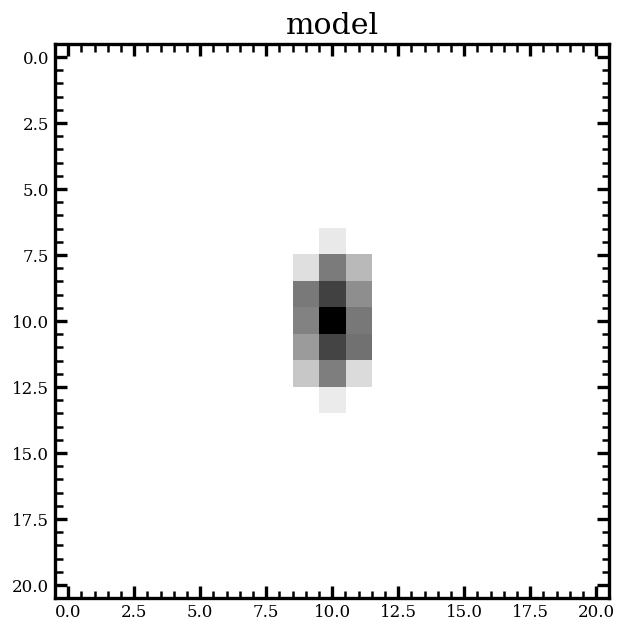

<Figure size 640x480 with 0 Axes>

In [429]:
# These should look far more like actual galaxies with the neural network acting as a constraint
fig, axes = plt.subplots(1, 1, figsize=(15,6),dpi=120)
y = scene_prior.sources[0].morphology() 
axes.imshow(y, cmap = cmap, interpolation=int_method) 
axes.set_title(f"model", fontsize = 18)
plt.show()
plt.clf()

# Lets take a look at the differences

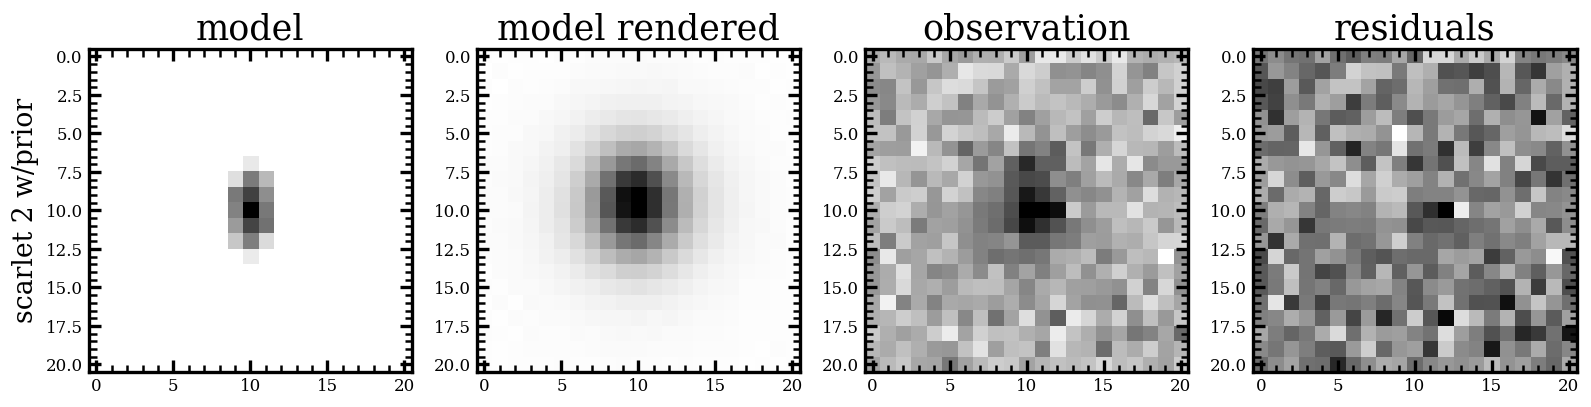

<Figure size 640x480 with 0 Axes>

In [430]:

fig, axes = plt.subplots(1, 4, figsize=(16,3.5),dpi=120)
#cmap = 'cmr.sepia'
band_list = ['g-band', 'r-band', 'i-band', 'y-band', 'z-band']

# ------------------ #
# Scarlet 2 plotting #
# ------------------ #

# the model
y = scene_prior.sources[0].morphology() 
axes[0].imshow(y, cmap = cmap,interpolation=int_method)
axes[0].set_title('model', fontsize = 21)
axes[0].set_ylabel('scarlet 2 w/prior', fontsize = 16)

# the renders
y2 = renders_prior[0]
axes[1].imshow(y2, cmap = cmap,interpolation=int_method)
axes[1].set_title('model rendered', fontsize = 21)

# the observations
axes[2].imshow(obs.data[0], cmap = cmap,interpolation=int_method)
axes[2].set_title('observation', fontsize = 21)

# the residuals
axes[3].imshow(obs.data[0] - y2, cmap = cmap)#'Greys')
axes[3].set_title('residuals', fontsize = 21)


#fig.tight_layout()
plt.savefig('bad_init_test_scar2.png', dpi=120)
plt.show()
plt.clf()

In [431]:
# load in scarlet 1 data
scarlet1_model = np.load('scarlet1_model.npy')
scarlet1_render = np.load('scarlet1_render.npy')
scarlet1_obs = np.load('scarlet1_obs.npy')
scarlet1_resid = np.load('scarlet1_resid.npy')

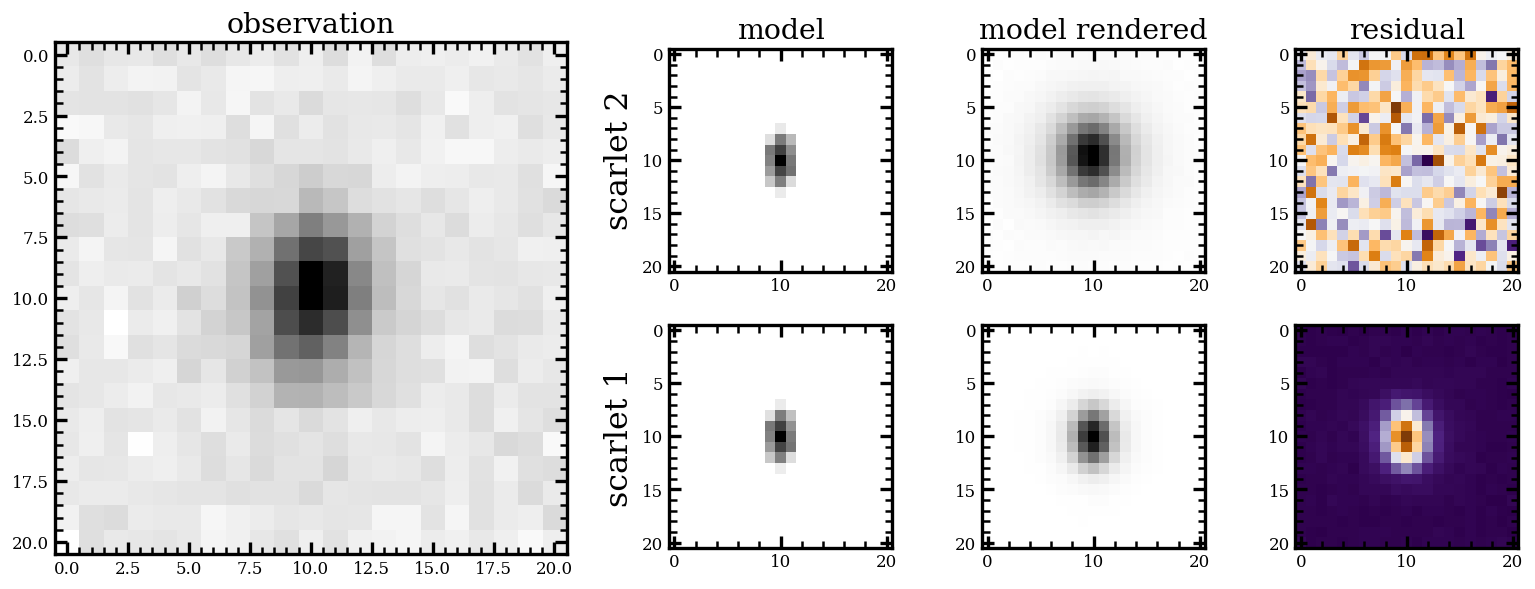

In [432]:
fig = plt.figure(figsize=(13,5),dpi=120)
cmap = 'binary'
cmap_resid = cmr.prinsenvlag
cmap_resid = 'PuOr'

# ------------------------------ #
# make the grid
gs = fig.add_gridspec(2,5)
ax1 = fig.add_subplot(gs[:, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[0, 4])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[1, 3])
ax7 = fig.add_subplot(gs[1, 4])
# ------------------------------ #

# ------------------------------ #
# Scarlet 2 plotting #
# the observations
#ax1.imshow(obs.data[i], cmap = cmap,interpolation=int_method)
ax1.imshow(scarlet1_obs, cmap = cmap,interpolation=int_method)
ax1.set_title('observation', fontsize = 17)

# the model
y = scene_prior.sources[0].morphology() 
ax2.imshow(y, vmin=0, cmap = cmap,interpolation=int_method)
ax2.set_title('model', fontsize = 17)
ax2.set_ylabel('scarlet 2', fontsize = 19)

# the renders
y2 = renders_prior[0]
ax3.imshow(y2, cmap = cmap,interpolation=int_method)
ax3.set_title('model rendered', fontsize = 17)

# the residuals
ax4.imshow(obs.data[i] - y2, cmap = cmap_resid)
ax4.set_title('residual', fontsize = 17)

# Scarlet 1 
# the model
ax5.imshow(scarlet1_model, cmap = cmap)
#ax5.set_title('model', fontsize = 17)
ax5.set_ylabel('scarlet 1', fontsize = 19)

# the renders
ax6.imshow(scarlet1_render, cmap = cmap)

# the residuals
ax7.imshow(scarlet1_resid, cmap = cmap_resid)
# ------------------------------ #

# save params
fig.tight_layout()
plt.savefig('bad_init_test.png', dpi=120)
plt.savefig('bad_init_test.pdf', dpi=120)
plt.show()